# Damage Monitoring Tools

The damage monitoring toolkit consists the files `SectionLib.py` and `get_fibers.py`, and the Python package `opensees`. Currently these files have to be copied to the location from where they are executed, and the `opensees` package should be installed by running the following command:

```shell
pip install opensees
```

The toolkit can be used from either Tcl, Python, or directly at the command line.

The following example shows how the `get_fibers.py` module may be invoked from Tcl:

```tcl
proc py {args} {
    eval "[exec python.exe {*}$args]"
}

foreach ds {dsr1 dsr2 dsr3} {
    py get_fibers.py modelDetails.json record-${ds}.txt -e 4020,3020 -d 60 -s $ds
}
```

> Note: This currently requires the `get_fibers.py` file to be visible from the current working directory
of the Tcl interpreter.

### 1) Geometry building

Damage regions are built from the same plane geometry primitives that are offered by OpenSees (e.g. the `patch` and `layer` commands).

Additionally, the function `section` from the module `opensees.render.mpl` can be used to visualize components.

In [40]:
from opensees import patch, layer, section
import opensees.render.mpl as render

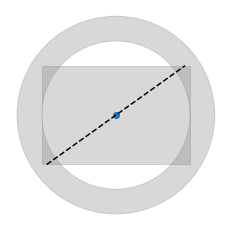

In [63]:
s = section.FiberSection(fibers=[
        patch.circ(extRad=20, intRad=15),
        layer.line(vertices=[[-14, -10], [14, 10]]),
        patch.rect(vertices=[[-15, -10], [15, 10]]),
])
render.section(s);

Print section properties:

In [64]:
print(s.area)
print(s.ixx)
print(s.iyy)
print(s.ixy)

1149.7787143782139
105902.9241215959
130902.9241215959
0.0


Additionally, the `SectionLib` module provides convenient wrappers for building  complex sections. 

The `Octagon` function from this library can be called in 3 ways:

- `Octagon(radius)` Constructs an octagon.
- `Octagon(extRad, intRad)` Constructs an octagonal annulus
- `Octagon(extRad, extRad)` (ie when both arguments are equal) Constructs an octagonal boundary line.

In [42]:
from SectionLib import Octagon

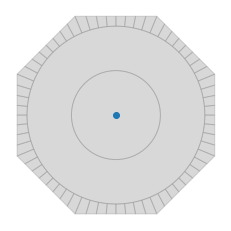

In [43]:
render.section(Octagon(20));

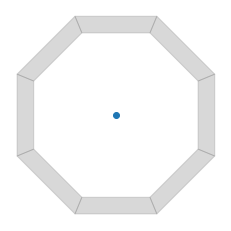

In [44]:
render.section(Octagon(20, 18));

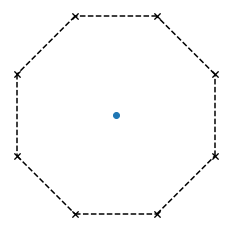

In [45]:
render.section(Octagon(20, 20), marker="x");

### 2) Define damage state regions; the `get_fibers` module

In [46]:
from get_fibers import iter_elem_fibers

The `get_fibers` module provides the helper function `iter_elem_fibers` for iterating
over a filtered collection of fibers. Fibers are filtered out by supplying a *damage state* dictionary with a required `"regions"` field, and optional `"material"` field.

In [47]:
inch, ft = 1, 12.0

In [48]:
Dcol = 7*ft
Rcol = Dcol/2
cover = 2*inch

In [49]:
DS = {
  # Any outermost cover fiber
  "dsr1" : {
      "regions": [
          Octagon(Dcol/2, Dcol/2)
      ]
  },
  "dsr2" : {
      "regions": [
          section.FiberSection(fibers=[
              patch.circ(intRad=Rcol-cover-2, extRad=Rcol-cover)
          ])
      ],
      "material": "*steel*"
  },
  "dsr3" : {
      "regions": [
      #             external radius         internal radius
          Octagon(Dcol/2-cover*(1-0.75), Dcol/2-cover*(1-0.5))
      ],
  },
}

### 3) Iterating over fibers

In [50]:
import json
import numpy as np

In [51]:
model_file = "modelDetails.json"
elements = [4020]

In [52]:
with open(model_file, "r") as f:
    model = json.load(f)

In [53]:
ds1_fibers = np.array([
    f["coord"] for e,s,f in iter_elem_fibers(elements, model, DS["dsr1"])
])

ds2_fibers = np.array([
    f["coord"] for e,s,f in iter_elem_fibers(elements, model, DS["dsr2"])
])

ds3_fibers = np.array([
    f["coord"] for e,s,f in iter_elem_fibers(elements, model, DS["dsr3"])
])

## 3) Visualizing

Patches can be superimposed for plotting purposes by adding them to a `Section` object like 
the one returned by the `Octagon` function. The `add_patches` method accepts a list
of `Patch` objects; this list is constructed in the following cell by concatenating
(`+` operator) the `patches` attributes of each of the previously defined damage regions.

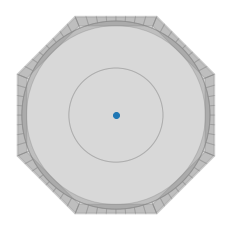

In [54]:
sect = Octagon(Dcol/2)
sect.add_patches(
    DS["dsr1"]["regions"][0].patches +
    DS["dsr2"]["regions"][0].patches +
    DS["dsr3"]["regions"][0].patches
)
ax = render.section(sect)

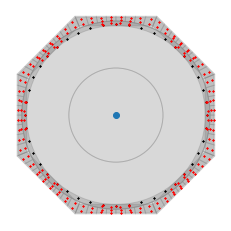

In [59]:
# Create grid of points
import numpy as np
ax = render.section(sect)
# ax.scatter(*list(zip(*ds1_fibers)), color="blue",  s=0.5)
ax.scatter(*list(zip(*ds2_fibers)), color="black", s=0.5)
ax.scatter(*list(zip(*ds3_fibers)), color="red",   s=0.5);

If the third argument to `iter_elem_fibers` is omitted, all fibers are returned (Underscores are used in the following cell to name unused variables).

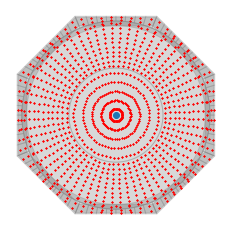

In [56]:
all_fibers = [f["coord"] for _,__,f in iter_elem_fibers([4020], model)]

ax = render.section(sect)
ax.scatter(*list(zip(*all_fibers)), color="red", s=0.5);